In [ ]:
# install library
!pip install roboflow
!pip install mediapipe
!pip install shap
!pip install opencv-python

In [ ]:
# import library
import roboflow
import mediapipe as mp
import cv2
import os
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
# Mediapipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [ ]:
# 이미지에서 특징을 추출하는 함수 정의
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    keypoints = []
    if results.pose_landmarks:
        mapping = {
            "wrist": [15, 16],
            "elbow": [13, 14],
            "shoulder": [11, 12]
        }
        for part, indices in mapping.items():
            for idx in indices:
                keypoints.extend([results.pose_landmarks.landmark[idx].x, results.pose_landmarks.landmark[idx].y])
    return keypoints

# 로보플로우에서 생성된 데이터셋 다운로드 링크
download_link = "https://app.roboflow.com/ds/2pyPAQpO2Y?key=zyxmZi1KqM"

# 데이터셋 저장할 경로 설정
dataset_path = "/content/dataset"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# 데이터셋 다운로드 및 압축 해제
os.system(f"wget {download_link} -O /content/dataset.zip")
os.system(f"unzip /content/dataset.zip -d {dataset_path}")

# 데이터 준비
data = []
class_mapping = {
    "Pull": 0,
    "Push": 1,
    "Middle": 2
}

class_data = {
    "Pull": [],
    "Push": [],
    "Middle": []
}

# 이미지에서 특징 추출하여 데이터셋 구성
for class_name, label in class_mapping.items():
    class_path = os.path.join(dataset_path, "train", class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        features = extract_features_from_image(image_path)
        data.append((features, label))
        class_data[class_name].append(features)

# 데이터셋을 X, y로 분리
X = np.array([d[0] for d in data])
y = np.array([d[1] for d in data])

In [ ]:
# 필요한 라이브러리 import
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Histogram-based gradient boosting classifier
gradient_model = HistGradientBoostingClassifier(max_iter=1000).fit(X, y)

#**성능평가**


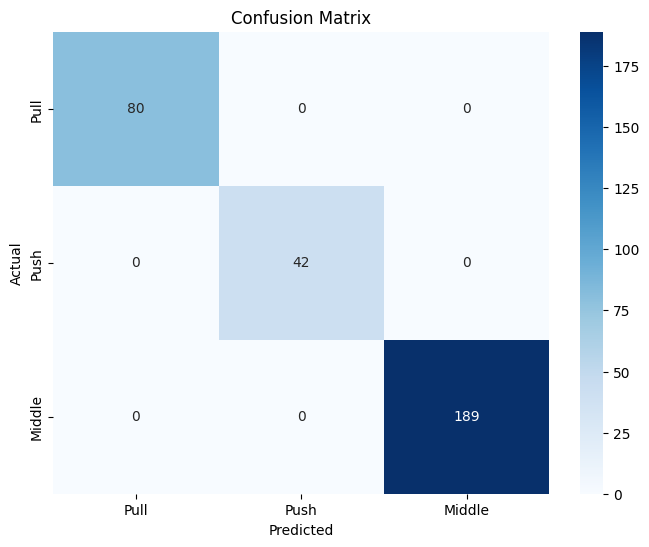

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


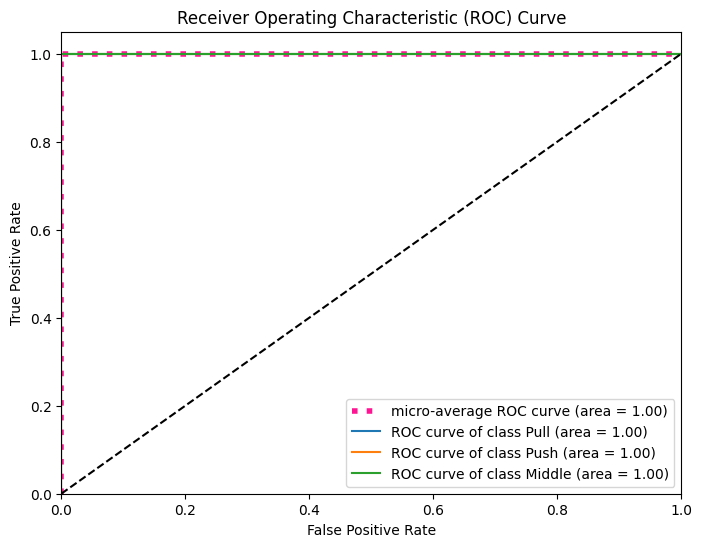

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# 예측값 계산
y_pred = gradient_model.predict(X)

# 혼동 행렬 계산
cm = confusion_matrix(y, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 정확도 계산
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 정밀도, 재현율, F1 점수 계산
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 클래스를 이진 분류로 변환
y_binarized = label_binarize(y, classes=[0, 1, 2])

# Gradient Boosting 모델 생성 및 학습
gradient_model = HistGradientBoostingClassifier(max_iter=1000).fit(X, y)

# 예측 확률 계산
y_scores = gradient_model.predict_proba(X)

# ROC curve 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve 및 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)

for i, class_name in enumerate(class_mapping.keys()):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
### Histogram-based gradient boosting classifier try1

# SHAP 분석을 위한 준비
explainer = shap.TreeExplainer(gradient_model, X)
shap_values = explainer.shap_values(X)

# 특징 이름 목록 설정
feature_names = [
    'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y',
    'left_elbow_x', 'left_elbow_y', 'right_elbow_x', 'right_elbow_y',
    'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x', 'right_shoulder_y'
]

 99%|===================| 923/933 [00:18<00:00]       

[[0.56031632 0.51910794 0.57093948 0.51670885 0.74110931 0.55438161
  0.6785056  0.50282139 0.73271734 0.36178413 0.67308891 0.33770686]
 [0.56339467 0.52685714 0.55504876 0.52522498 0.75552654 0.54459131
  0.66296828 0.49523267 0.72201425 0.36080703 0.6493274  0.33574325]
 [0.51409537 0.50593746 0.51429397 0.47908688 0.69876218 0.54964387
  0.63021654 0.48726645 0.68273926 0.35453451 0.63887578 0.33356947]
 [0.54902476 0.52325982 0.55982727 0.50197875 0.72685635 0.56153226
  0.6783461  0.49945569 0.73734844 0.36377379 0.68282491 0.33937994]
 [0.51442337 0.63993865 0.52503473 0.59384382 0.76507628 0.68433607
  0.67446434 0.5947811  0.74796242 0.44412607 0.71318847 0.42065963]
 [0.57740915 0.58050478 0.56367463 0.550331   0.76191956 0.53756303
  0.65429097 0.49168462 0.72552198 0.35893837 0.66065007 0.34069157]
 [0.50554955 0.60599065 0.54291481 0.5395354  0.76387411 0.63110435
  0.72676045 0.58101678 0.79345614 0.37907982 0.7569406  0.37437361]
 [0.48444051 0.62433124 0.50436139 0.5809

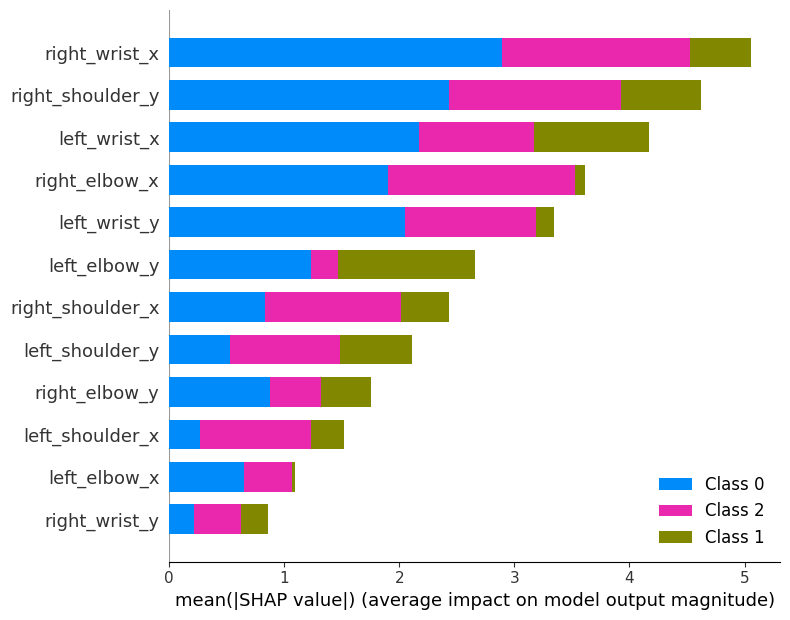

[[0.27403691 0.36202499 0.27929333 0.36295766 0.48530701 0.37964746
  0.47165695 0.37522751 0.71616852 0.33977088 0.6749208  0.33297217]
 [0.21479726 0.42316094 0.23201309 0.42043075 0.46680844 0.450838
  0.46823606 0.4373166  0.80251557 0.43386641 0.73315597 0.4186669 ]
 [0.29194832 0.49779502 0.32346684 0.48989981 0.50186092 0.46143293
  0.51674867 0.45104608 0.7113089  0.35328424 0.69619918 0.34355277]
 [0.16253561 0.45899954 0.17865807 0.45692831 0.42341232 0.45815745
  0.42638272 0.44938231 0.7540797  0.41615933 0.69510853 0.40957588]
 [0.16239572 0.5086025  0.17313141 0.50390828 0.43504843 0.50430775
  0.40097898 0.49548879 0.75545818 0.43878442 0.68403751 0.44043437]
 [0.17341505 0.45665437 0.17882323 0.46062717 0.43254966 0.46107405
  0.41957533 0.45973831 0.75241017 0.41753906 0.68468362 0.41776842]
 [0.0213545  0.44492918 0.15756008 0.43655866 0.29469061 0.48107284
  0.36541837 0.41588527 0.64730811 0.41672796 0.62068993 0.39477241]
 [0.16886193 0.51148027 0.20992929 0.507413

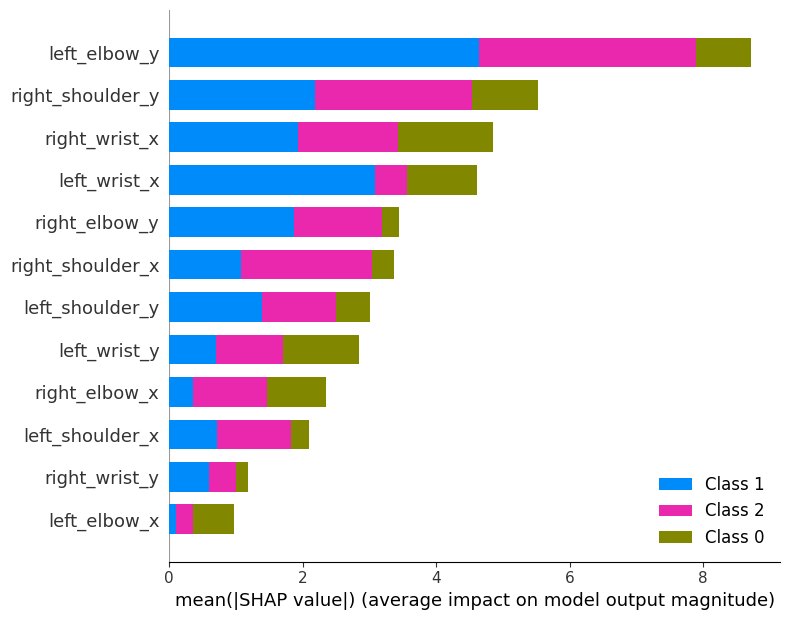

[[0.32311872 0.4980703  0.33232683 ... 0.37710112 0.62796426 0.36418095]
 [0.35523167 0.49915403 0.38100025 ... 0.365165   0.75535518 0.35616335]
 [0.31608108 0.49278015 0.35547158 ... 0.43466383 0.74044216 0.42392311]
 ...
 [0.42567122 0.55854166 0.43676975 ... 0.37980828 0.68173099 0.36906767]
 [0.45822409 0.6036461  0.47387594 ... 0.45054287 0.73467481 0.42205921]
 [0.37869528 0.51455605 0.38423547 ... 0.37704006 0.68709916 0.36709672]]


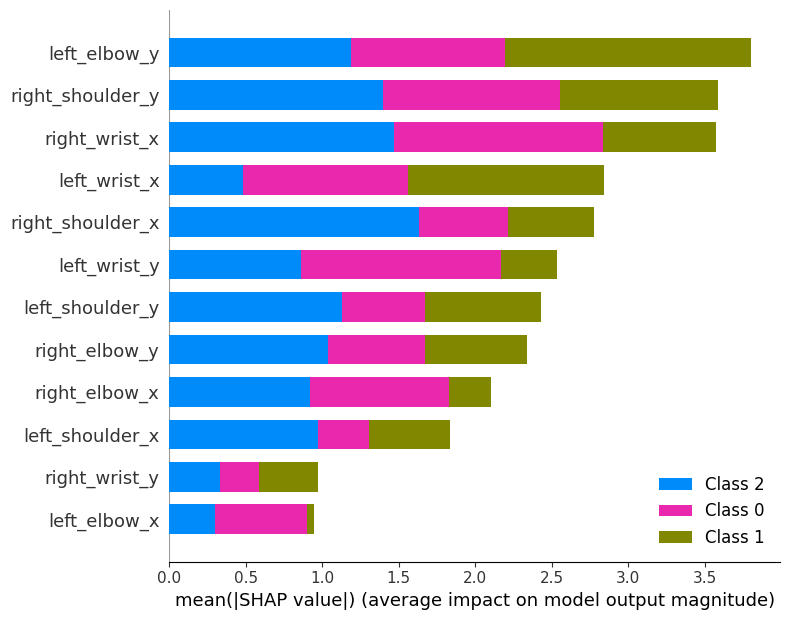

In [ ]:
# 클래스별 SHAP 분석 및 시각화
for class_name, class_features in class_data.items():
    class_features = np.array(class_features)
    class_X = X[y == class_mapping[class_name]]

    # 특정 관절 인덱스 설정
    wrist_left_idx = feature_names.index('left_wrist_x')
    wrist_right_idx = feature_names.index('right_wrist_x')
    elbow_left_idx = feature_names.index('left_elbow_x')
    elbow_right_idx = feature_names.index('right_elbow_x')
    shoulder_left_idx = feature_names.index('left_shoulder_x')
    shoulder_right_idx = feature_names.index('right_shoulder_x')
    feature_indices = [
        wrist_left_idx, wrist_left_idx + 1, wrist_right_idx, wrist_right_idx + 1,
        elbow_left_idx, elbow_left_idx + 1, elbow_right_idx, elbow_right_idx + 1,
        shoulder_left_idx, shoulder_left_idx + 1, shoulder_right_idx, shoulder_right_idx + 1
    ]

    # 특정 관절만을 가지고 SHAP 값을 다시 계산
    print(class_X)
    class_X_selected = class_X[:, feature_indices]
    shap_values_class = explainer.shap_values(class_X_selected)

    # SHAP 그래프 생성
    shap.summary_plot(
        shap_values_class, class_X_selected,
        feature_names=feature_names,
    )

In [ ]:
#for key, value in class_data.items():
    #print(key)

a = class_data.keys()
a

dict_keys(['Pull', 'Push', 'Middle'])

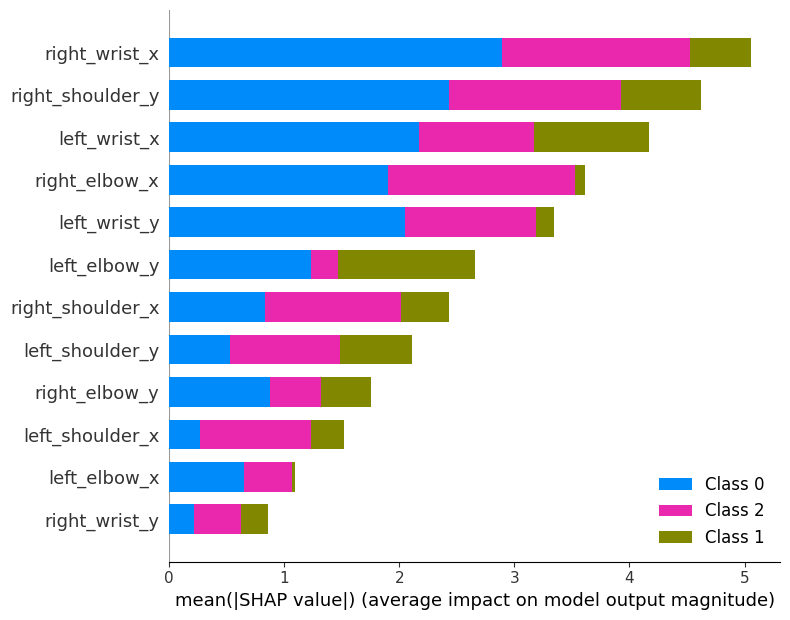

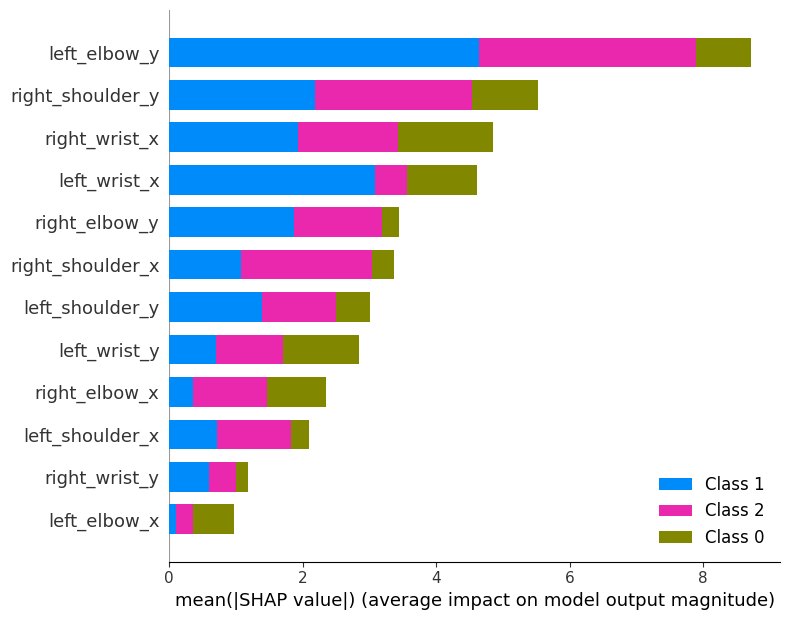

 99%|===================| 562/567 [00:12<00:00]       

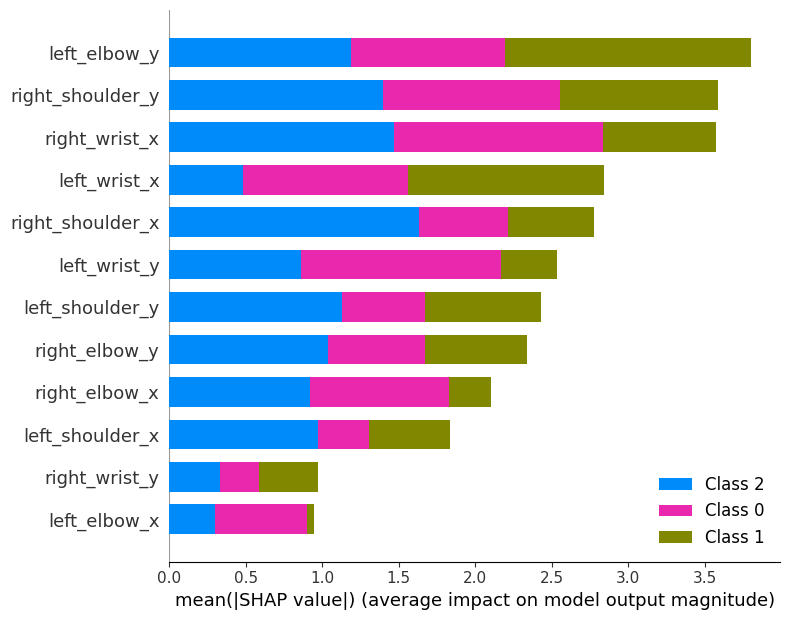

In [ ]:
# 클래스별 SHAP 분석 및 시각화
for class_name, class_features in class_data.items():
    class_features = np.array(class_features)
    class_X = X[y == class_mapping[class_name]]

    # 특정 관절 인덱스 설정
    wrist_left_idx = feature_names.index('left_wrist_x')
    wrist_right_idx = feature_names.index('right_wrist_x')
    elbow_left_idx = feature_names.index('left_elbow_x')
    elbow_right_idx = feature_names.index('right_elbow_x')
    shoulder_left_idx = feature_names.index('left_shoulder_x')
    shoulder_right_idx = feature_names.index('right_shoulder_x')
    feature_indices = [
        wrist_left_idx, wrist_left_idx + 1, wrist_right_idx, wrist_right_idx + 1,
        elbow_left_idx, elbow_left_idx + 1, elbow_right_idx, elbow_right_idx + 1,
        shoulder_left_idx, shoulder_left_idx + 1, shoulder_right_idx, shoulder_right_idx + 1
    ]

    # 특정 관절만을 가지고 SHAP 값을 다시 계산
    class_X_selected = class_X[:, feature_indices]
    shap_values_class = explainer.shap_values(class_X_selected)

    # SHAP 그래프 생성
    shap.summary_plot(
        shap_values_class, class_X_selected,
        feature_names=feature_names,
    )

In [ ]:
shap_values_np = np.array(shap_values)

# Summary plot

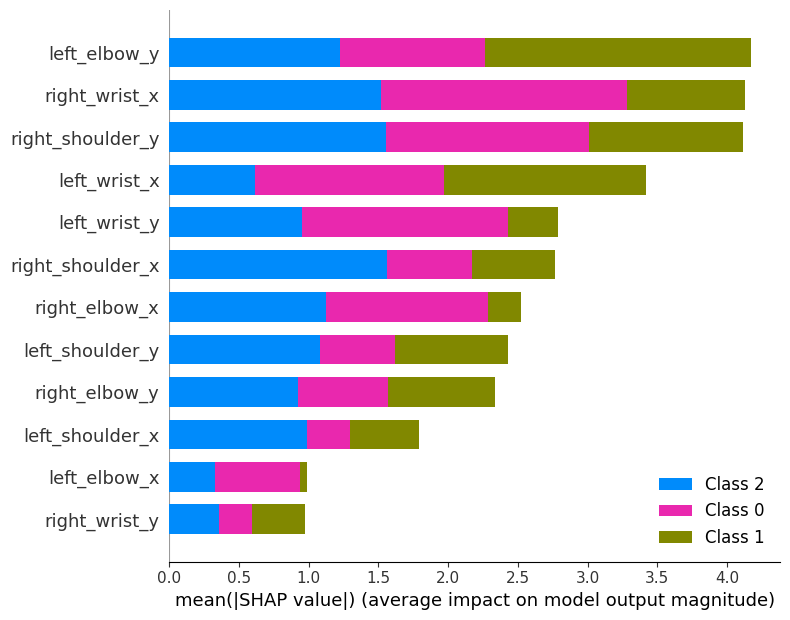

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X, feature_names=feature_names)

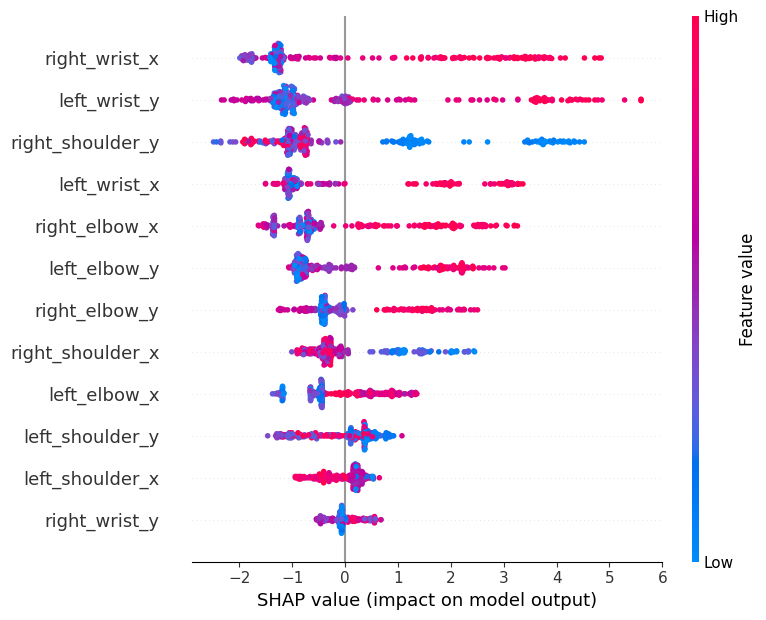

In [ ]:
shap.summary_plot(shap_values[0], X, feature_names=feature_names)
# print(feature_value)

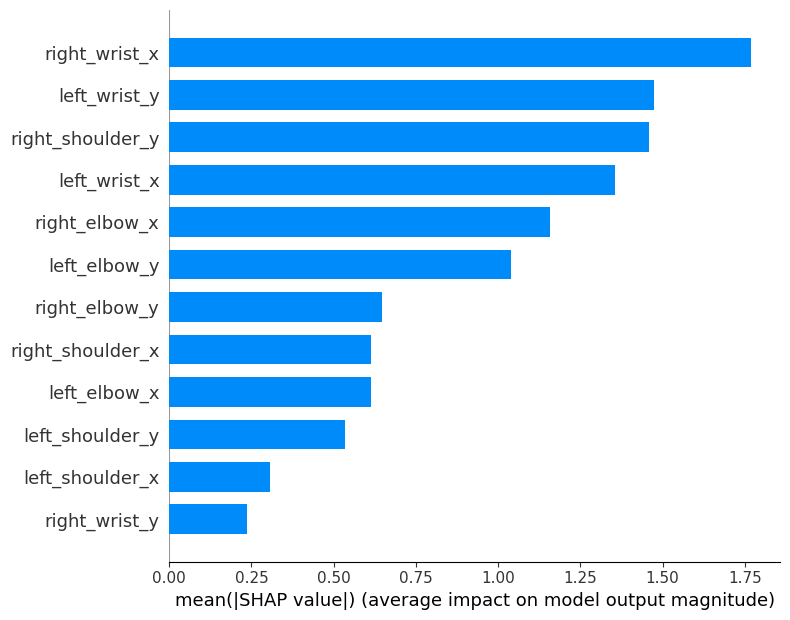

In [ ]:
shap.summary_plot(shap_values[0], X, feature_names=feature_names, plot_type='bar')

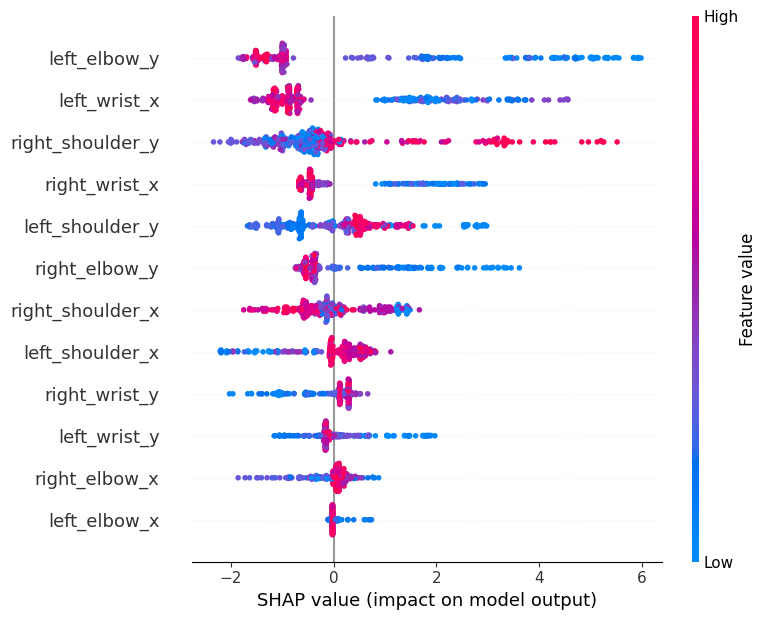

In [ ]:
shap.summary_plot(shap_values[1], X, feature_names=feature_names)

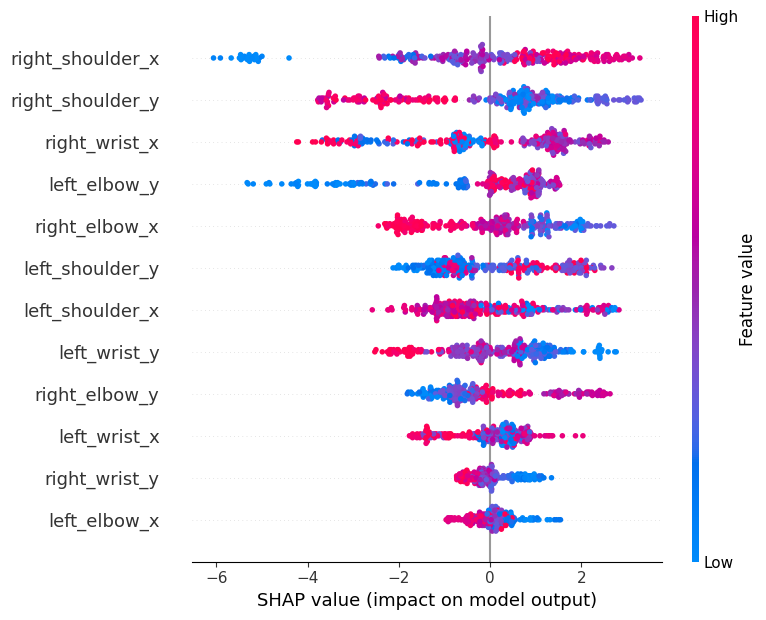

In [ ]:
shap.summary_plot(shap_values[2], X, feature_names=feature_names)

# Force Plot

In [ ]:
# SHAP Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_class[0][0,:],
                class_X_selected[0,:], feature_names=feature_names)

In [ ]:
# SHAP Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_class[1][0,:],
                class_X_selected[0,:], feature_names=feature_names)

In [ ]:
# SHAP Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values_class[2][0,:],
                class_X_selected[0,:], feature_names=feature_names)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X)

# Depedence plot

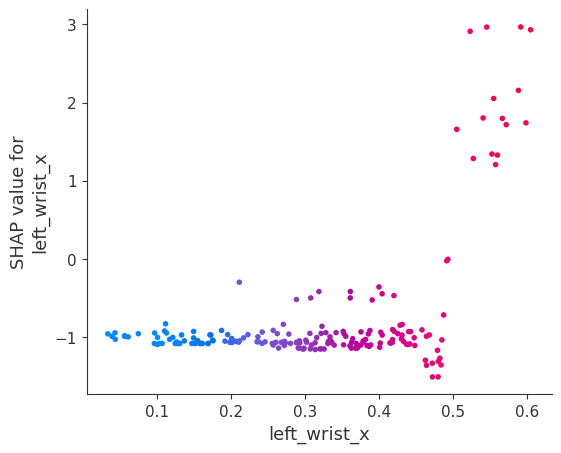

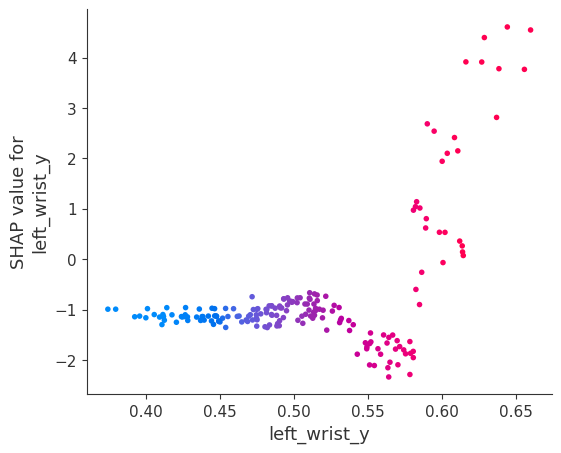

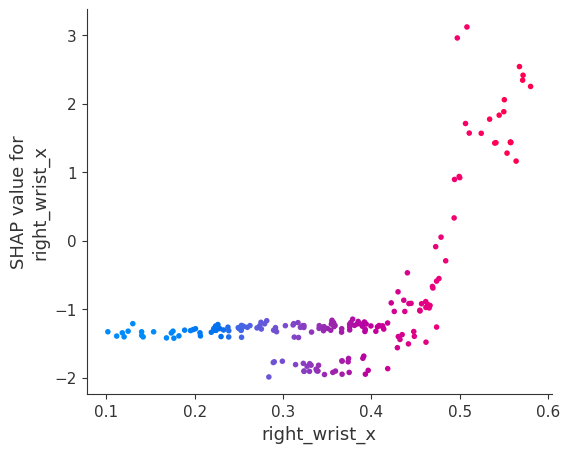

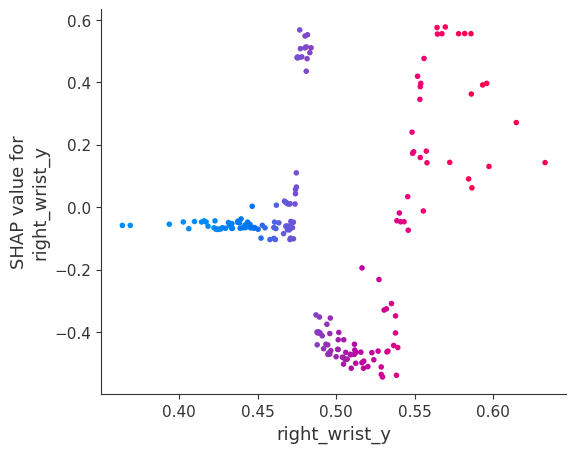

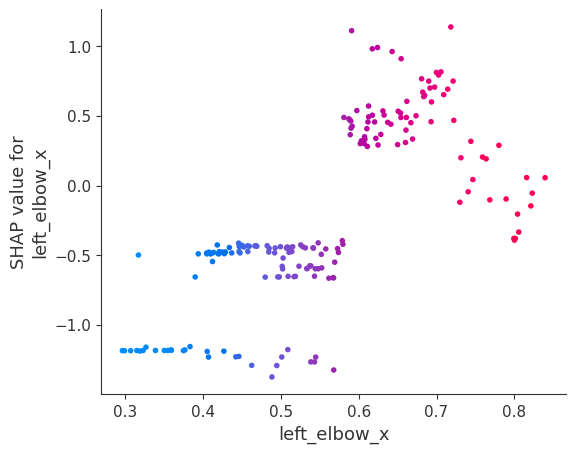

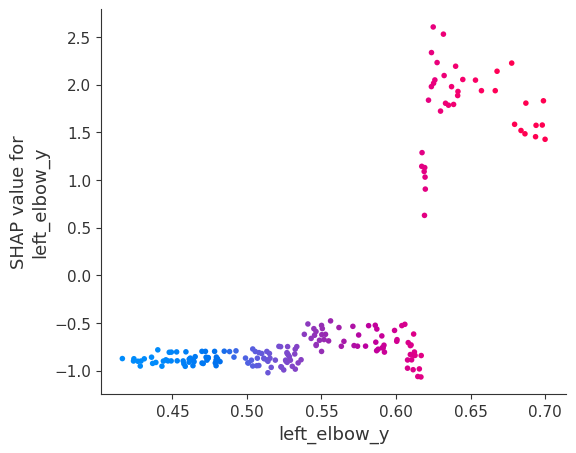

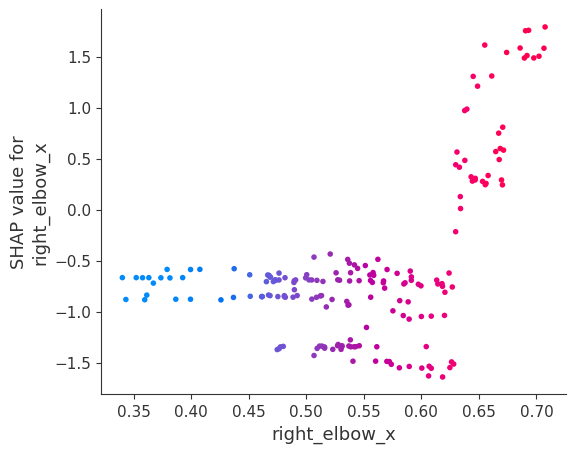

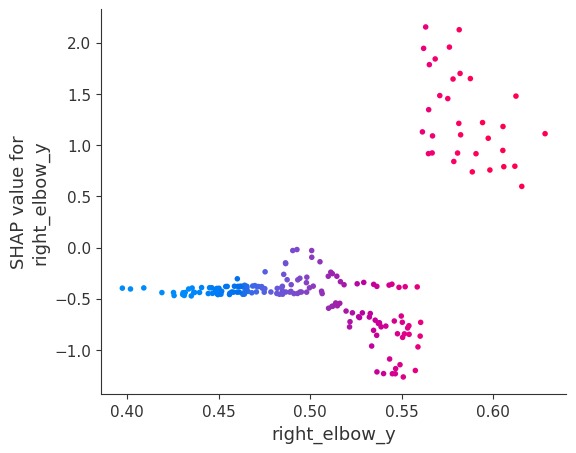

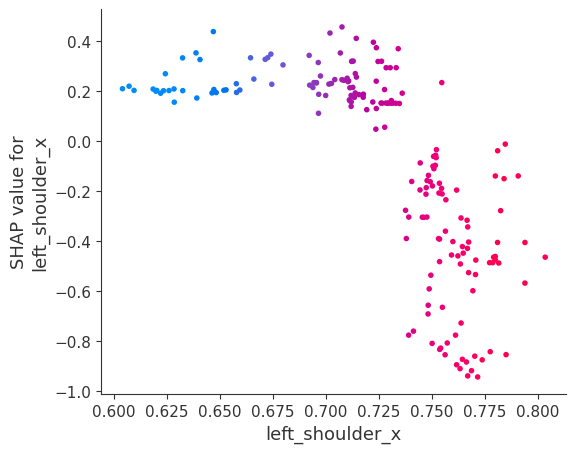

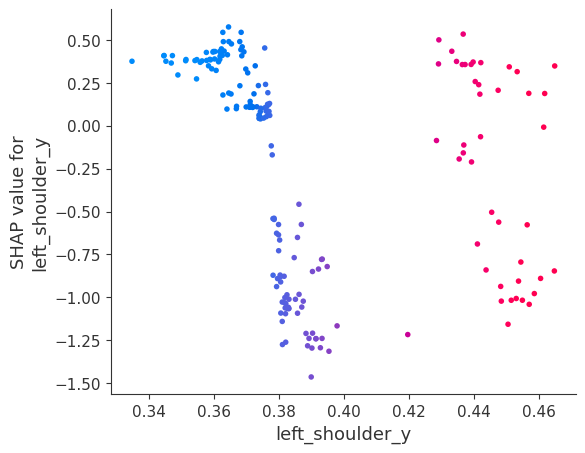

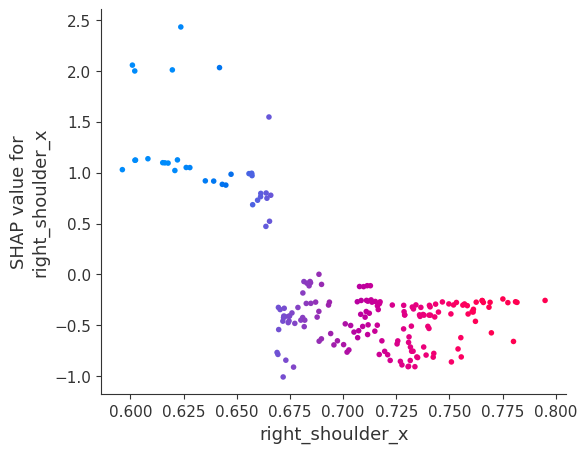

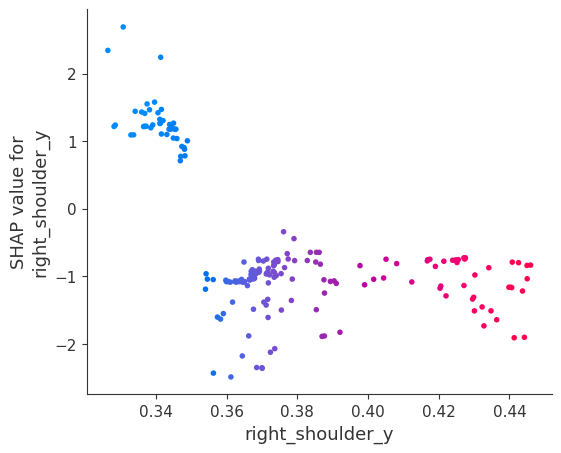

In [ ]:
for feature_name in feature_names:
    shap.dependence_plot(
        feature_name,
        shap_values_class[0],
        class_X_selected,
        feature_names=feature_names,
        interaction_index=feature_name)

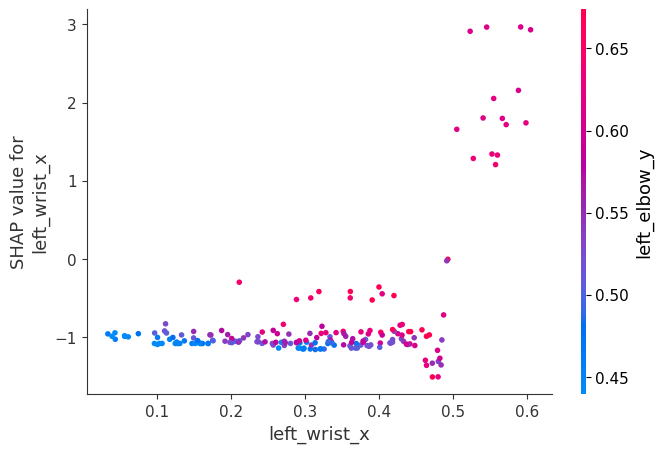

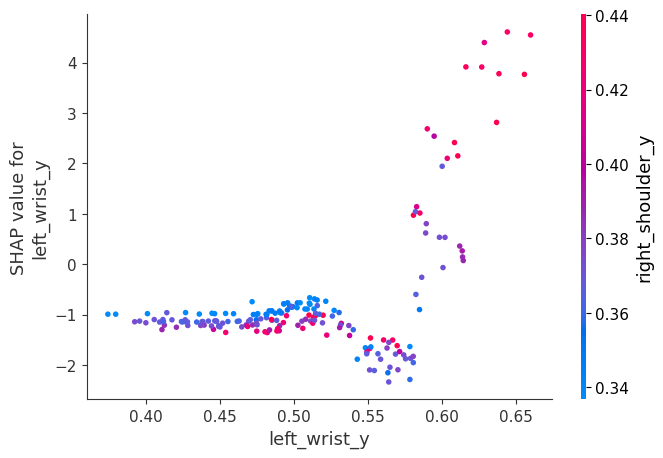

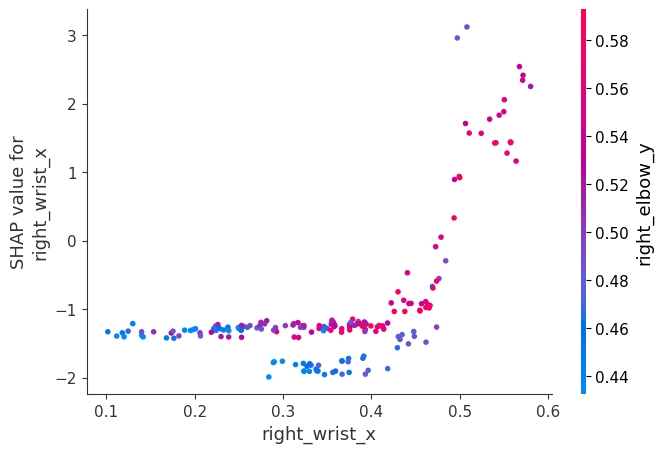

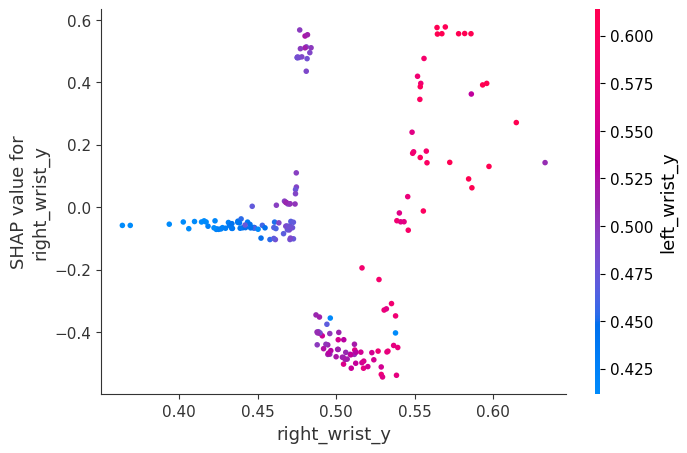

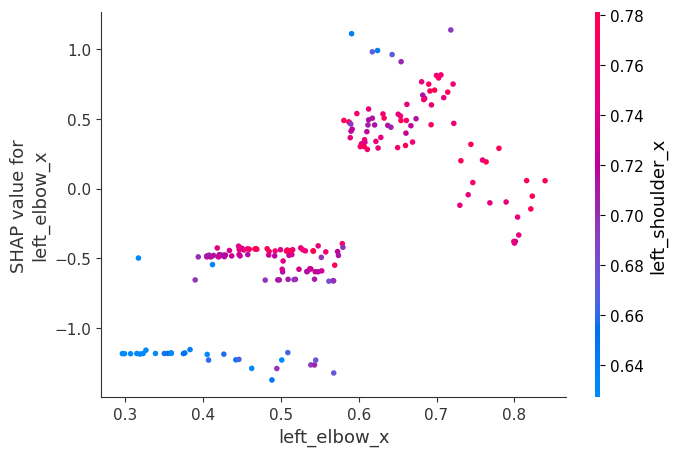

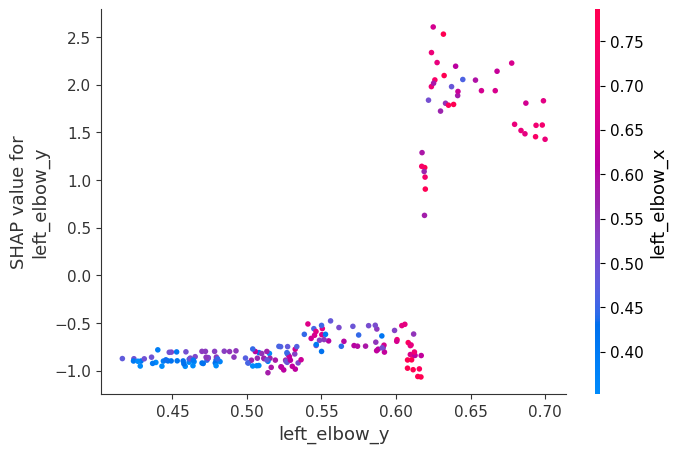

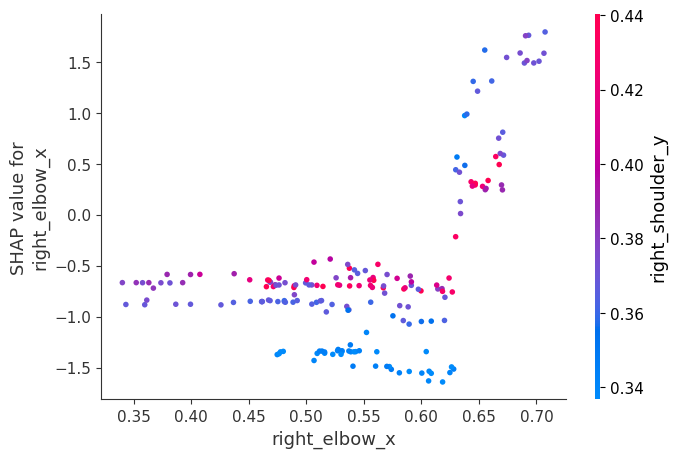

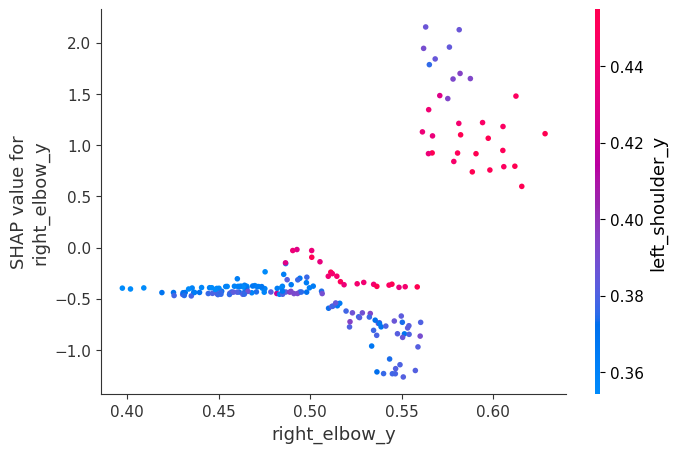

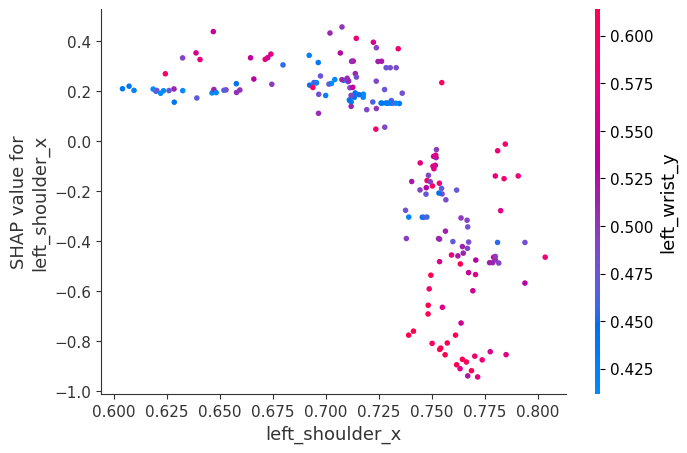

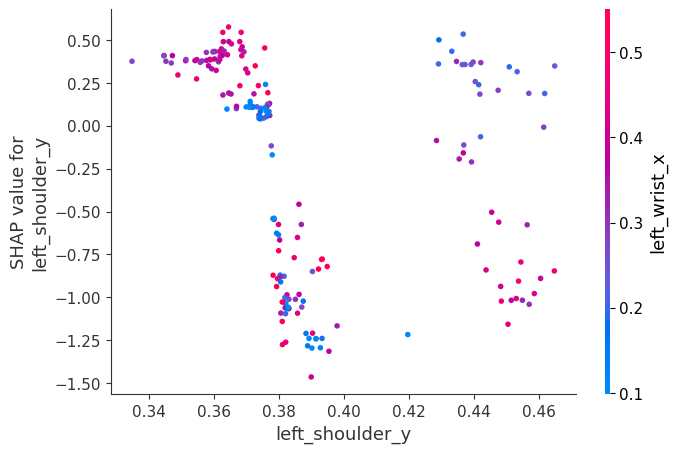

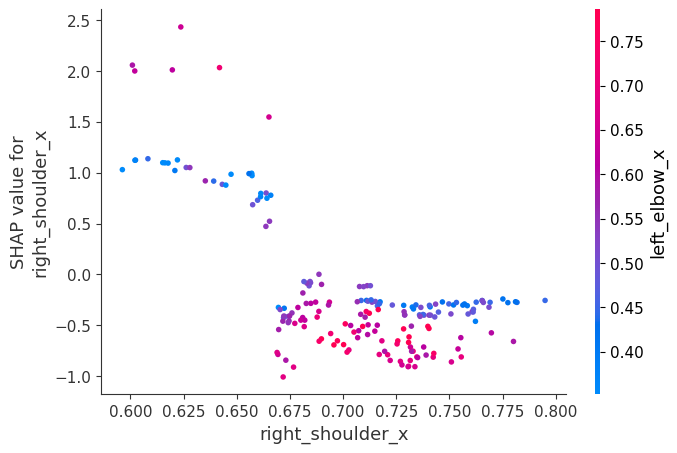

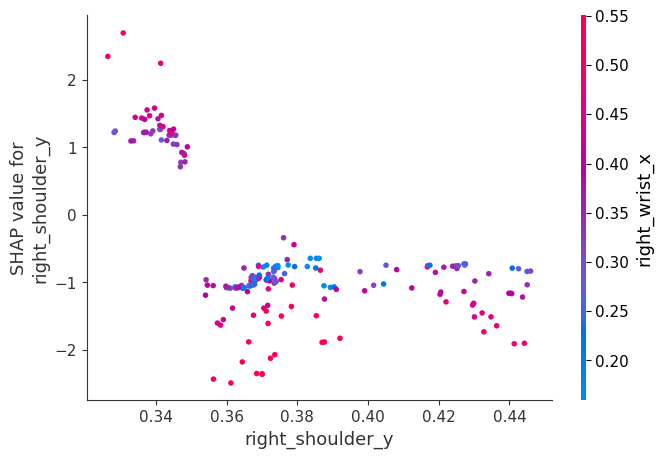

In [ ]:
for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values_class[0], class_X_selected, feature_names=feature_names)
